In [1]:
# Enable interactive plot
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import json
import datetime as dt
import matplotlib.dates as md
import matplotlib.animation as animation

In [13]:
# Load log file
file = "../capybot/capybot.log"

def load_data():

    prices = {}
    strategies = {}
    orders = {}
    
    with open(file) as f:
        for line in f:
            data = json.loads(line)

            if 'msg' not in data:
                continue

            match data['msg']:
                case "price":
                    entry = data['price']
                    source = entry['source'];
                    price = entry['price'];
                    if source not in prices:
                        prices[source] = {
                            'offset': entry['price'],
                            'price': [],
                            'time': [],
                        }
                    prices[source]['price'].append(price)
                    prices[source]['time'].append(data['time'] / 1000)
                    
                case "strategies":
                    for strategy in data['strategies']:
                        strategies[strategy] = {};
                        strategies[strategy]['parameters'] = data['strategies'][strategy];
                        strategies[strategy]['statuses'] = {
                            'value': [],
                            'time': []  
                        }

                case "strategy status":
                    strategy = data['uri']
                    entry = data['data'];
                    strategies[strategy]['statuses']['value'].append(entry)
                    strategies[strategy]['statuses']['time'].append(data['time'] / 1000)
                    
                case "order":
                    strategy = data['uri']
                    if strategy not in orders:
                        orders[strategy] = {
                            'a2b':  [],
                            'time':  [],
                        }
                    orders[strategy]['a2b'].append(data['decision']['a2b']);
                    orders[strategy]['time'].append(data['time'] / 1000);
                    
                case _:
                    continue
    
    return {
        'prices': prices, 
        'strategies': strategies,
        'orders': orders
    }
                    

<IPython.core.display.Javascript object>


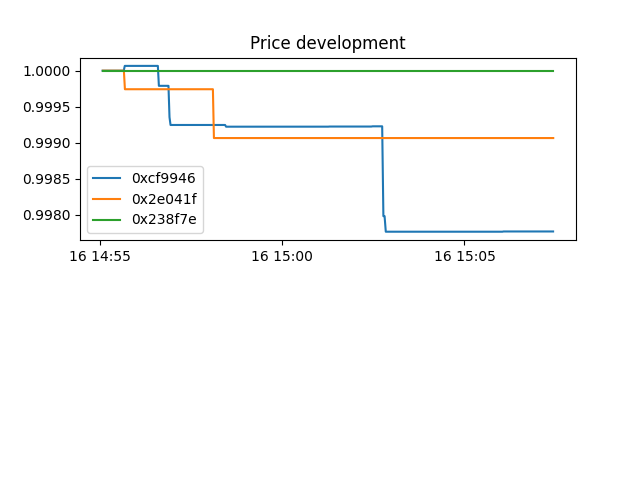

In [14]:
# Plot of prices of all pools
fig, ax = plt.subplots(1,1)

def animate_prices(j):
    data = load_data();
    ax.clear()
    ax.set_title('Price development')
    for source in data['prices']:
        prices = data['prices'][source]['price'];
        normalized = np.multiply(prices, 1 / data['prices'][source]['offset'])    
        timestamps = data['prices'][source]['time'];
        dates = [dt.datetime.fromtimestamp(ts) for ts in timestamps]
        ax.plot(dates, normalized, label = source[0:8])
    ax.legend();

anim1 = animation.FuncAnimation(fig, animate_prices, interval=1000)
fig.show()

<IPython.core.display.Javascript object>


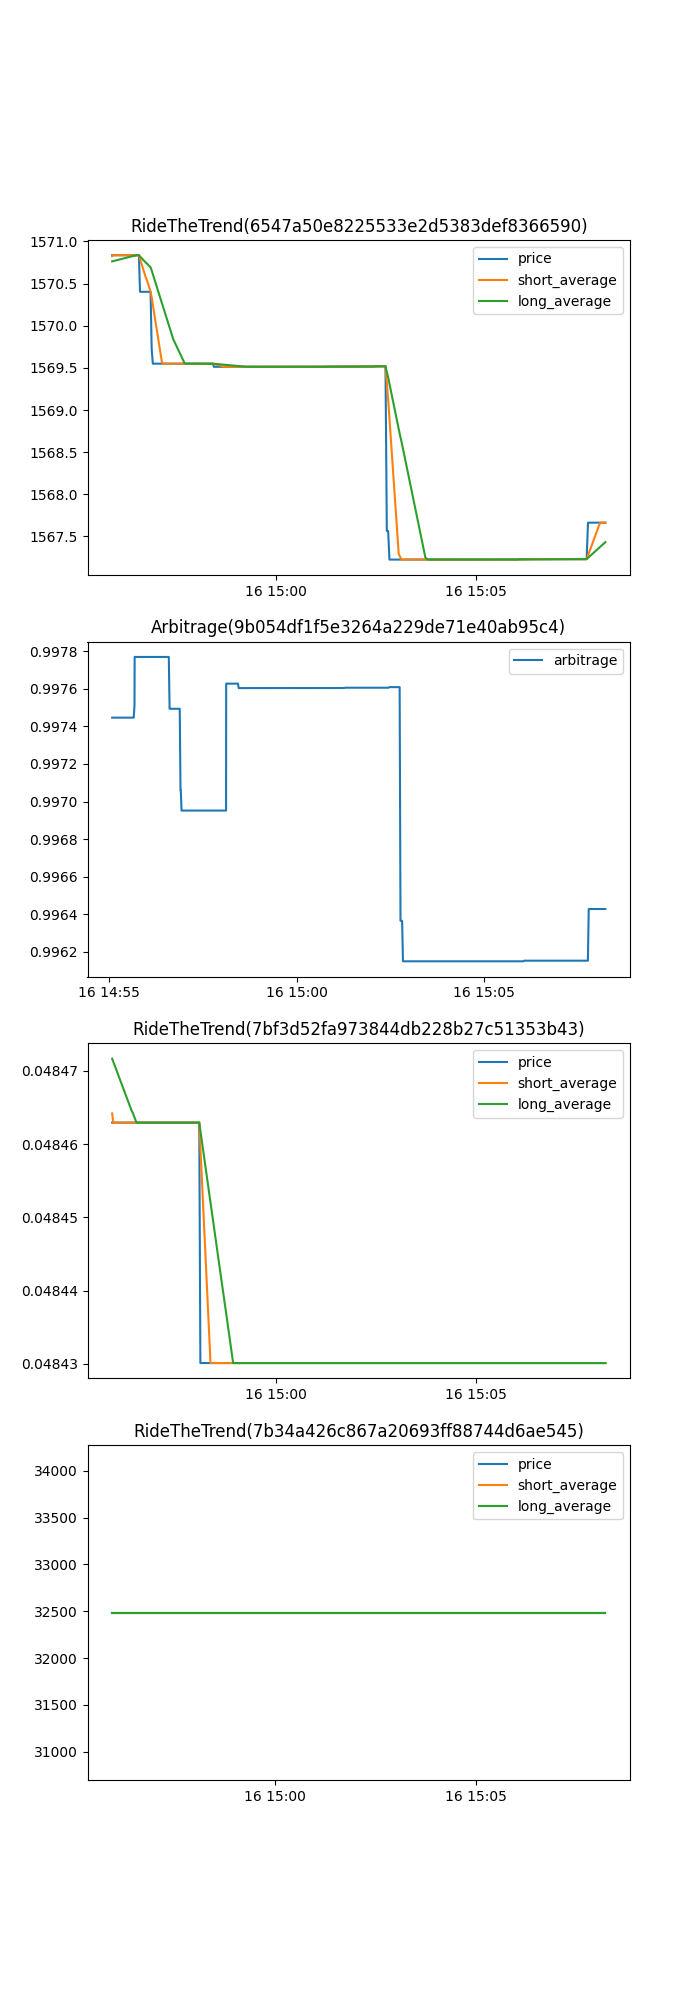

{}


In [19]:
# Plot statuses for all used strategies 
data = load_data();
number_of_strategies = len(data['strategies'])
plt.subplots_adjust(bottom=0.5)
fig, ax = plt.subplots(number_of_strategies, 1, figsize = (7, 5 * number_of_strategies))

def animate_strategies(j):
    data = load_data();
    for i, uri in enumerate(data['strategies']):
        strategy = data['strategies'][uri]
        ax[i].clear()
        ax[i].set_title(strategy['parameters']['name'] + "(" + uri + ")")

        timestamps = strategy['statuses']['time']
        dates = [dt.datetime.fromtimestamp(ts) for ts in timestamps]

        if len(strategy['statuses']['value']) == 0:
            break

        keys = strategy['statuses']['value'][0].keys()
        for key in keys:
            y = list(map(lambda x: x[key], strategy['statuses']['value']))
            ax[i].plot(dates, y, label = key)
        ax[i].legend();
        
anim2 = animation.FuncAnimation(fig, animate_strategies, interval=1000)
fig.show()